# Neural Network

## Load Data

In [1]:
from timeit import default_timer as timer
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import helper
import numpy as np
import tensorflow as tf

In [3]:
# load mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build Netwrok

In [4]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

In [5]:
class Network(object):
    
    def __init__(self, x_dim, n_classes, p_l1_w, p_l1_b, p_l2_w, p_l2_b):
        # Inputs
        self.p_l1_w = p_l1_w
        self.p_l1_b = p_l1_b
        self.p_l2_w = p_l2_w
        self.p_l2_b = p_l2_b
        self.init_placeholders(x_dim, n_classes)
        # Model
        self.logits = self.build()
        self.prediction = tf.nn.softmax(self.logits)
        # Loss and Optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, 
            labels=self.y))
        self.optimizer = tf.train.GradientDescentOptimizer(0.003).minimize(self.cost)
        # Accuracy
        correct_pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.prediction, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    def init_placeholders(self, x_dim, n_classes):
        self.x = tf.placeholder(tf.float32, [None, x_dim], name='x')
        self.y = tf.placeholder(tf.int64, [None, 10], name='y')
        # dimension: batch_size, x
        self.l1_w = tf.Variable(self.p_l1_w, dtype=tf.float32, name='l1_w')
        self.l1_b = tf.Variable(self.p_l1_b, dtype=tf.float32, name='l1_b')
        self.l2_w = tf.Variable(self.p_l2_w, dtype=tf.float32, name='l2_w')
        self.l2_b = tf.Variable(self.p_l2_b, dtype=tf.float32, name='l2_b')

    def build(self):
        l1_a = tf.sigmoid(tf.nn.bias_add(tf.matmul(self.x, self.l1_w), self.l1_b))
        logits = tf.nn.bias_add(tf.matmul(l1_a, self.l2_w), self.l2_b)
        return logits

In [6]:
def print_stats(session, net, total_epochs, epoch, batch_i, feature_batch, label_batch):
    train_loss = session.run(net.cost, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_loss = session.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels})
    train_accuracy = session.run(net.accuracy, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_accuracy = session.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels})
    print('Epoch {:>2}/{:>2}, CIFAR-10 Batch {} | Train Acc: {:1.2} Loss: {:1.3} | Valid Acc: {:1.2} Loss: {:1.3}'.format(
        epoch, total_epochs, batch_i, train_accuracy, train_loss, valid_accuracy, valid_loss), end='\r')

In [7]:
def truncated_normal(mean=0.0, stddev=0.1, minval=-1.0, maxval=1.0):
    return np.clip(np.random.normal(mean, stddev), minval, maxval)

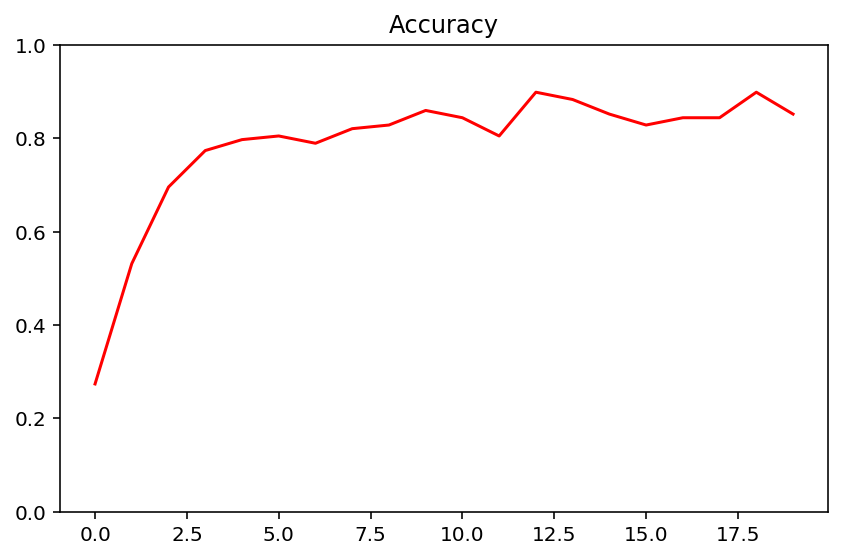

In [341]:
batch_size = 128
x_dim = 784
n_classes = 10
epochs = 20

with tf.Session() as sess:
    
    l1_w = [[truncated_normal() for _ in range(100)] for _ in range(x_dim)]
    l1_b = np.zeros(100)
    l2_w = [[truncated_normal() for _ in range(10)] for _ in range(100)]
    l2_b = np.zeros(10)

    net = Network(x_dim, n_classes, l1_w, l1_b, l2_w, l2_b)
    sess.run(tf.global_variables_initializer())
    accuracies = []
    # Initializing the variables
    for e in range(epochs):
        batch_num = mnist.train.num_examples//batch_size
        for ii in range(batch_num):
            train_batch, labels = mnist.train.next_batch(batch_size)
            train_batch = train_batch*2-1

            # Run optimizers
            feed_dict = {net.x:train_batch,
                         net.y:labels}
            _ = sess.run([net.optimizer], feed_dict=feed_dict)
            logits, predict, accuracy = sess.run([net.logits, net.prediction, net.accuracy], feed_dict=feed_dict)
            
        accuracies.append(accuracy)

    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(epochs), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()

# Genetic Algorithm

In [8]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from operator import attrgetter
import string
import random
import time

In [9]:
__DEBUG__ = False
batch_size = 64
x_dim = 784
n_classes = 10

In [14]:
class Individual(object):
    
    def __init__(self, generation):
        self.accuracy = -1
        self.evaluation_time = 0.0
        self.generation = generation
                
        # define penalties
        self.loss_mult = .1
        self.accuracy_mult = 3
        self.accuracy_delta_mult = 5
        self.penalty = 99999
        
        self.network_epochs = 5
        self.max_time = 30
        
    def generate(self):
        self.gene = {}
        # l1_w 
        self.gene[0] = np.random.randn(x_dim, 100)
        # l1_b 
        self.gene[1] = np.random.randn(100)
        # l2_w 
        self.gene[2] = np.random.randn(100, 10)
        # l2_b 
        self.gene[3] = np.random.randn(10)
        
    def fitness(self):
        tf.reset_default_graph()
        with tf.Session() as sess:
            net = Network(x_dim, 
                          n_classes,
                          self.gene[0],
                          self.gene[1], 
                          self.gene[2], 
                          self.gene[3])
            sess.run(tf.global_variables_initializer())
            
            values = []
            batch_num = mnist.train.num_examples//batch_size
            for ii in range(batch_num):
                train_batch, labels = mnist.train.next_batch(batch_size)
                # Run optimizers
                feed_dict = {net.x: train_batch,
                             net.y: labels}
                values += sess.run([net.accuracy], feed_dict=feed_dict)
            self.accuracy = np.mean(values)

    def cross_over(self, parent, recombination_probability=.5):
        child = {}
        # Complete Continuous Recombination
        child[0] = (self.gene[0][:] + parent.gene[0][:])/2.
        child[1] = (self.gene[1][:] + parent.gene[1][:])/2.
        child[2] = (self.gene[2][:] + parent.gene[2][:])/2.
        child[3] = (self.gene[3][:] + parent.gene[3][:])/2.
        
        ''' 
        # Continuous Recombination
        for ii, g in enumerate(child[0]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[0][ii] = (g + parent.gene[0][ii])/2.
    
        for ii, g in enumerate(child[1]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[1][ii] = (g + parent.gene[1][ii])/2.
        
        for ii, g in enumerate(child[2]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[2][ii] = (g + parent.gene[2][ii])/2.
        
        for ii, g in enumerate(child[3]):
            prob = np.random.sample()
            if prob <= recombination_probability:
                child[3][ii] = (g + parent.gene[3][ii])/2.
        '''
                    
        individ = Individual(generation=self.generation)
        individ.gene = child
        return individ
        
    def mutate(self, mutation_rate=.05):
        prob = np.random.sample()

        if prob <= mutation_rate:
            tf.reset_default_graph()
            with tf.Session() as sess:
                net = Network(x_dim, 
                              n_classes,
                              self.gene[0],
                              self.gene[1], 
                              self.gene[2], 
                              self.gene[3])
                sess.run(tf.global_variables_initializer())
                
                batch_num = mnist.train.num_examples//batch_size
                for ii in range(batch_num):
                    train_batch, labels = mnist.train.next_batch(batch_size)
                    # Run optimizers
                    feed_dict = {net.x: train_batch,
                                 net.y: labels}
                    _ = sess.run([net.optimizer], feed_dict=feed_dict)
                self.gene[0] = sess.run(net.l1_w)
                self.gene[1] = sess.run(net.l1_b)
                self.gene[2] = sess.run(net.l2_w)
                self.gene[3] = sess.run(net.l2_b)
        

In [15]:
class Population(object):
    
    def __init__(self,
                 initial_population=200, 
                 max_generations=1000,
                 mutation_rate=0.01, 
                 elitism=True,
                 tournament_size=4,
                 solution_threshold=.99):
        self.initial_population = initial_population
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism = elitism
        self.tournament_size = tournament_size
        self.solution_threshold = solution_threshold
        self.time_elapsed = 0.0
        self.global_best_individual = None
        self.global_best_solution = 0.0
        self.current_best_individual = None
        self.current_best_solution = 0.0
        self.generation = 0
        self.population = []

    def _evaluate_best_(self):
        self.current_best_individual = self._evaluate_current_best_individual_()
        self.current_best_solution = self.current_best_individual.accuracy
        if self.global_best_individual == None or self.global_best_solution < self.current_best_solution:
            self.global_best_individual = self.current_best_individual
            self.global_best_solution = self.current_best_solution

    def _perform_tournament_selection_(self):
        tournament = Population()
        tournament.generation = self.generation
        for _ in range(self.tournament_size):
            i = random.choice(self.population)
            tournament.add_individual(i)
        return tournament._evaluate_current_best_individual_()
    
    def _evaluate_current_best_individual_(self):
        return max(self.population, key=attrgetter('accuracy'))
    
    def evaluate_fitnesses(self):
        population_length = len(self.population)
        for i, p in enumerate(self.population):
            if p.accuracy < 0:
                p.fitness()
                print('{}/{}, Accuracy {}'.format(i+1, 
                                                  population_length, 
                                                  p.accuracy))
        self._evaluate_best_()
    
    def generate(self):
        assert self.initial_population > 0
        self.population = [Individual(generation=self.generation) for _ in range(self.initial_population)]
        for p in self.population:
            p.generate()
    
    def evolve_generation(self):
        children_genes = []
        self.evaluate_fitnesses()  
        
        if self.elitism:
            children_genes.append(self.current_best_individual)
            
        for _ in range(self.initial_population):
            # perform selection
            male = self._perform_tournament_selection_()
            female = self._perform_tournament_selection_()
            # perform cross-over
            new_individual = male.cross_over(female)
            new_individual.generation = self.generation
            # perform mutation
            new_individual.mutate(self.mutation_rate)
            children_genes.append(new_individual)
            
        self.population = children_genes
        self.generation += 1
    
    def found_solution(self):
        return self.global_best_solution >= self.solution_threshold
    
    def add_individual(self, individual):
        self.population.append(individual)
    
    def print_accuracy(self):
        if self.generation == 0:
            return
        print('Generation: {}/{}, Solution accuracy: {}'.format(
            self.generation, 
            self.max_generations,
            self.global_best_solution))    

In [16]:
# hypter-parameters
max_generations = 100
population_size = 20
mutation_rate = 1.

In [17]:
def execute(max_generations, population_size, mutation_rate, display_interval=1):
    population = Population(population_size, max_generations)
    population.generate()
    accuracies = []
    while not population.found_solution() and population.generation < max_generations:
        population.evolve_generation()
        if population.generation % display_interval == 0:
            population.print_accuracy()
        accuracies.append(population.global_best_individual.accuracy)
    best_individual = population.global_best_individual
    print('\nCompleted {} generations:\nFinal accuracy: {}, Generation: {}'.format(
        population.generation, 
        best_individual.accuracy, 
        best_individual.generation))
    
    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(len(accuracies)), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()
    
    return best_individual

1/20, Accuracy 0.08869324624538422
2/20, Accuracy 0.11645081639289856
3/20, Accuracy 0.10544601082801819
4/20, Accuracy 0.1235630065202713
5/20, Accuracy 0.08769281208515167
6/20, Accuracy 0.10157159715890884
7/20, Accuracy 0.08490978181362152
8/20, Accuracy 0.09162180125713348
9/20, Accuracy 0.13194848597049713
10/20, Accuracy 0.09687864035367966
11/20, Accuracy 0.06650174409151077
12/20, Accuracy 0.09002110362052917
13/20, Accuracy 0.10084400326013565
14/20, Accuracy 0.17307552695274353
15/20, Accuracy 0.11595968902111053
16/20, Accuracy 0.13100261986255646
17/20, Accuracy 0.0651920810341835
18/20, Accuracy 0.0845823660492897
19/20, Accuracy 0.09056679159402847
20/20, Accuracy 0.10457290709018707
Generation: 1/100, Solution accuracy: 0.17307552695274353
2/21, Accuracy 0.15184807777404785
3/21, Accuracy 0.1221260204911232
4/21, Accuracy 0.1097387969493866
5/21, Accuracy 0.07657887041568756
6/21, Accuracy 0.13640497624874115
7/21, Accuracy 0.07677895575761795
8/21, Accuracy 0.107883438

19/21, Accuracy 0.36859720945358276
20/21, Accuracy 0.39882856607437134
21/21, Accuracy 0.39828288555145264
Generation: 11/100, Solution accuracy: 0.4283141791820526
2/21, Accuracy 0.38442230224609375
3/21, Accuracy 0.42720460891723633
4/21, Accuracy 0.3974643349647522
5/21, Accuracy 0.4127073585987091
6/21, Accuracy 0.50874924659729
7/21, Accuracy 0.4138351380825043
8/21, Accuracy 0.4118342697620392
9/21, Accuracy 0.4280049502849579
10/21, Accuracy 0.41259822249412537
11/21, Accuracy 0.3840221166610718
12/21, Accuracy 0.41157960891723633
13/21, Accuracy 0.3996107280254364
14/21, Accuracy 0.41243451833724976
15/21, Accuracy 0.3979554772377014
16/21, Accuracy 0.38474971055984497
17/21, Accuracy 0.3965730369091034
18/21, Accuracy 0.39931970834732056
19/21, Accuracy 0.38371288776397705
20/21, Accuracy 0.3973006308078766
21/21, Accuracy 0.4134167730808258
Generation: 12/100, Solution accuracy: 0.50874924659729
2/21, Accuracy 0.41980135440826416
3/21, Accuracy 0.4613831341266632
4/21, Accur

18/21, Accuracy 0.6147409677505493
19/21, Accuracy 0.6220169067382812
20/21, Accuracy 0.615886926651001
21/21, Accuracy 0.6236357688903809
Generation: 22/100, Solution accuracy: 0.6338583827018738
2/21, Accuracy 0.6322941184043884
3/21, Accuracy 0.6287652850151062
4/21, Accuracy 0.6308934688568115
5/21, Accuracy 0.6224898099899292
6/21, Accuracy 0.628037691116333
7/21, Accuracy 0.6272737383842468
8/21, Accuracy 0.628437876701355
9/21, Accuracy 0.627873957157135
10/21, Accuracy 0.6283287405967712
11/21, Accuracy 0.6268917322158813
12/21, Accuracy 0.6302204728126526
13/21, Accuracy 0.6237267255783081
14/21, Accuracy 0.6320394277572632
15/21, Accuracy 0.6281104683876038
16/21, Accuracy 0.6306933760643005
17/21, Accuracy 0.6248545050621033
18/21, Accuracy 0.6324759721755981
19/21, Accuracy 0.6201797127723694
20/21, Accuracy 0.6325669288635254
21/21, Accuracy 0.6313664317131042
Generation: 23/100, Solution accuracy: 0.6338583827018738
2/21, Accuracy 0.6330034732818604
3/21, Accuracy 0.62834

18/21, Accuracy 0.6542673110961914
19/21, Accuracy 0.6735848188400269
20/21, Accuracy 0.6607246994972229
21/21, Accuracy 0.6626891493797302
Generation: 33/100, Solution accuracy: 0.6735848188400269
2/21, Accuracy 0.6704925894737244
3/21, Accuracy 0.6668546199798584
4/21, Accuracy 0.6692193150520325
5/21, Accuracy 0.6712565422058105
6/21, Accuracy 0.6697831749916077
7/21, Accuracy 0.6697468161582947
8/21, Accuracy 0.6664908528327942
9/21, Accuracy 0.6718568205833435
10/21, Accuracy 0.6689100861549377
11/21, Accuracy 0.6708563566207886
12/21, Accuracy 0.66887366771698
13/21, Accuracy 0.6690555810928345
14/21, Accuracy 0.6738576889038086
15/21, Accuracy 0.6704379916191101
16/21, Accuracy 0.6695103049278259
17/21, Accuracy 0.6688919067382812
18/21, Accuracy 0.6730573177337646
19/21, Accuracy 0.6714929938316345
20/21, Accuracy 0.6676185727119446
21/21, Accuracy 0.6704379916191101
Generation: 34/100, Solution accuracy: 0.6738576889038086
2/21, Accuracy 0.6701833605766296
3/21, Accuracy 0.671

18/21, Accuracy 0.7020881772041321
19/21, Accuracy 0.7023974061012268
20/21, Accuracy 0.6990504860877991
21/21, Accuracy 0.7034524083137512
Generation: 44/100, Solution accuracy: 0.7045801877975464
2/21, Accuracy 0.702488362789154
3/21, Accuracy 0.7019062638282776
4/21, Accuracy 0.7017061710357666
5/21, Accuracy 0.7011241316795349
6/21, Accuracy 0.7016334533691406
7/21, Accuracy 0.7016879916191101
8/21, Accuracy 0.7022700905799866
9/21, Accuracy 0.7019972205162048
10/21, Accuracy 0.7026156783103943
11/21, Accuracy 0.7014515399932861
12/21, Accuracy 0.7007239460945129
13/21, Accuracy 0.7027794122695923
14/21, Accuracy 0.7001054883003235
15/21, Accuracy 0.7043254971504211
16/21, Accuracy 0.6992323994636536
17/21, Accuracy 0.7018880844116211
18/21, Accuracy 0.7019245028495789
19/21, Accuracy 0.703088641166687
20/21, Accuracy 0.7019426822662354
21/21, Accuracy 0.7005056738853455
Generation: 45/100, Solution accuracy: 0.7045801877975464
2/21, Accuracy 0.702324628829956
3/21, Accuracy 0.7017

17/21, Accuracy 0.7218058705329895
18/21, Accuracy 0.7283905744552612
19/21, Accuracy 0.7250072956085205
20/21, Accuracy 0.7251527905464172
21/21, Accuracy 0.72749924659729
Generation: 55/100, Solution accuracy: 0.7290999889373779
2/21, Accuracy 0.7258076071739197
3/21, Accuracy 0.7273537516593933
4/21, Accuracy 0.7239886522293091
5/21, Accuracy 0.7271354794502258
6/21, Accuracy 0.7251346111297607
7/21, Accuracy 0.7245525121688843
8/21, Accuracy 0.7390497922897339
9/21, Accuracy 0.7231882810592651
10/21, Accuracy 0.728299617767334
11/21, Accuracy 0.7258076071739197
12/21, Accuracy 0.7261532545089722
13/21, Accuracy 0.724388837814331
14/21, Accuracy 0.7264806628227234
15/21, Accuracy 0.7254074215888977
16/21, Accuracy 0.7242615222930908
17/21, Accuracy 0.7262623906135559
18/21, Accuracy 0.7253892421722412
19/21, Accuracy 0.7263533473014832
20/21, Accuracy 0.7253710627555847
21/21, Accuracy 0.7258622050285339
Generation: 56/100, Solution accuracy: 0.7390497922897339
2/21, Accuracy 0.7307

16/21, Accuracy 0.7510186433792114
17/21, Accuracy 0.750163733959198
18/21, Accuracy 0.749199628829956
19/21, Accuracy 0.7528921961784363
20/21, Accuracy 0.7477990388870239
21/21, Accuracy 0.7523828744888306
Generation: 66/100, Solution accuracy: 0.7584036588668823
2/21, Accuracy 0.750436544418335
3/21, Accuracy 0.7543837428092957
4/21, Accuracy 0.7500909566879272
5/21, Accuracy 0.7496179938316345
6/21, Accuracy 0.7546929717063904
7/21, Accuracy 0.7488176822662354
8/21, Accuracy 0.7525283694267273
9/21, Accuracy 0.7508912682533264
10/21, Accuracy 0.7518189549446106
11/21, Accuracy 0.7535833716392517
12/21, Accuracy 0.7507275938987732
13/21, Accuracy 0.7549476027488708
14/21, Accuracy 0.7536015510559082
15/21, Accuracy 0.7527830600738525
16/21, Accuracy 0.7522555589675903
17/21, Accuracy 0.7528194189071655
18/21, Accuracy 0.7490723133087158
19/21, Accuracy 0.7534924149513245
20/21, Accuracy 0.7512732744216919
21/21, Accuracy 0.7533105611801147
Generation: 67/100, Solution accuracy: 0.75

15/21, Accuracy 0.7606046199798584
16/21, Accuracy 0.7635877728462219
17/21, Accuracy 0.7601862549781799
18/21, Accuracy 0.7616596221923828
19/21, Accuracy 0.7628601789474487
20/21, Accuracy 0.7624781727790833
21/21, Accuracy 0.759749710559845
Generation: 77/100, Solution accuracy: 0.7648428678512573
2/21, Accuracy 0.7632785439491272
3/21, Accuracy 0.7602044343948364
4/21, Accuracy 0.7611867189407349
5/21, Accuracy 0.7613868117332458
6/21, Accuracy 0.762587308883667
7/21, Accuracy 0.7610048055648804
8/21, Accuracy 0.7621325850486755
9/21, Accuracy 0.7596951127052307
10/21, Accuracy 0.7644608616828918
11/21, Accuracy 0.7617687582969666
12/21, Accuracy 0.7620779871940613
13/21, Accuracy 0.7605500817298889
14/21, Accuracy 0.7605864405632019
15/21, Accuracy 0.7619143128395081
16/21, Accuracy 0.7634240388870239
17/21, Accuracy 0.7606592178344727
18/21, Accuracy 0.759949803352356
19/21, Accuracy 0.7632057666778564
20/21, Accuracy 0.762114405632019
21/21, Accuracy 0.7603135704994202
Generatio

14/21, Accuracy 0.7668073177337646
15/21, Accuracy 0.7629328966140747
16/21, Accuracy 0.7643699049949646
17/21, Accuracy 0.7616778016090393
18/21, Accuracy 0.7666072249412537
19/21, Accuracy 0.7610411643981934
20/21, Accuracy 0.765825092792511
21/21, Accuracy 0.7610775828361511
Generation: 88/100, Solution accuracy: 0.7695357799530029
2/21, Accuracy 0.7661888599395752
3/21, Accuracy 0.7667527794837952
4/21, Accuracy 0.7636786699295044
5/21, Accuracy 0.7661161422729492
6/21, Accuracy 0.7644426822662354
7/21, Accuracy 0.7677531838417053
8/21, Accuracy 0.7657159566879272
9/21, Accuracy 0.7659887671470642
10/21, Accuracy 0.7655340433120728
11/21, Accuracy 0.765388548374176
12/21, Accuracy 0.7666618227958679
13/21, Accuracy 0.7678077816963196
14/21, Accuracy 0.7664071321487427
15/21, Accuracy 0.765825092792511
16/21, Accuracy 0.7693721055984497
17/21, Accuracy 0.7605136632919312
18/21, Accuracy 0.765861451625824
19/21, Accuracy 0.7678077816963196
20/21, Accuracy 0.7650611400604248
21/21, Ac

14/21, Accuracy 0.775411069393158
15/21, Accuracy 0.7728463411331177
16/21, Accuracy 0.7750654816627502
17/21, Accuracy 0.7736648917198181
18/21, Accuracy 0.7729554772377014
19/21, Accuracy 0.7738649845123291
20/21, Accuracy 0.7737376093864441
21/21, Accuracy 0.7746652960777283
Generation: 99/100, Solution accuracy: 0.7757384777069092
2/21, Accuracy 0.7737376093864441
3/21, Accuracy 0.7734102010726929
4/21, Accuracy 0.7750291228294373
5/21, Accuracy 0.7737558484077454
6/21, Accuracy 0.7739558815956116
7/21, Accuracy 0.7741742134094238
8/21, Accuracy 0.7743924856185913
9/21, Accuracy 0.7742287516593933
10/21, Accuracy 0.7729372978210449
11/21, Accuracy 0.7732647061347961
12/21, Accuracy 0.7740104794502258
13/21, Accuracy 0.7750473022460938
14/21, Accuracy 0.7744833827018738
15/21, Accuracy 0.7734102010726929
16/21, Accuracy 0.7727553844451904
17/21, Accuracy 0.7739923000335693
18/21, Accuracy 0.7742105722427368
19/21, Accuracy 0.7759203910827637
20/21, Accuracy 0.7714093327522278
21/21,

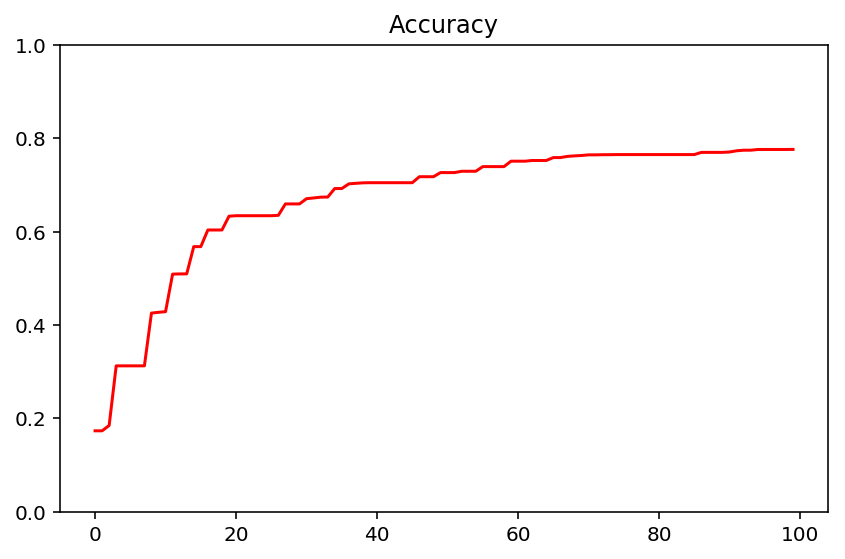

In [18]:
best_individ = execute(max_generations, population_size, mutation_rate)

## Test Model - MNIST

In [19]:
with tf.Session() as sess:
    net = Network(x_dim, 
                  n_classes,
                  best_individ.gene[0],
                  best_individ.gene[1], 
                  best_individ.gene[2], 
                  best_individ.gene[3])
    sess.run(tf.global_variables_initializer())

    values = []
    batch_num = mnist.test.num_examples//batch_size
    for ii in range(batch_num):
        train_batch, labels = mnist.test.next_batch(batch_size)
        # Run optimizers
        feed_dict = {net.x: train_batch,
                     net.y: labels}
        values += sess.run([net.accuracy], feed_dict=feed_dict)
    accuracy = np.mean(values)
    print('Validation accuracy: ', accuracy)

Validation accuracy:  0.782853


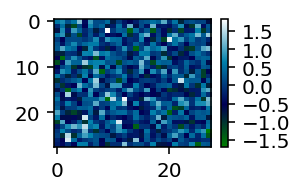

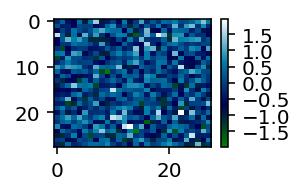

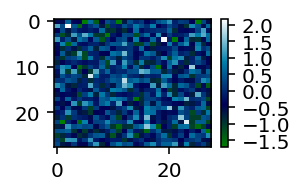

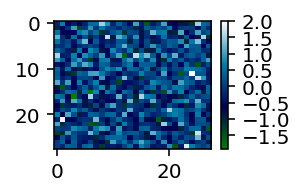

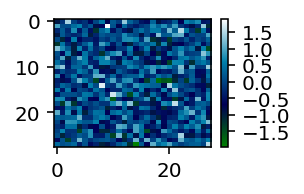

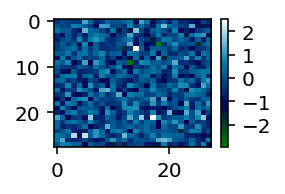

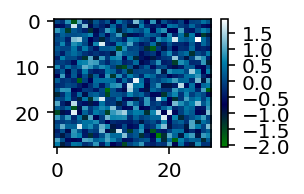

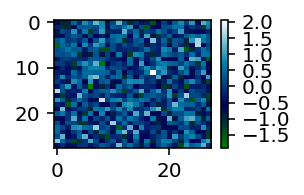

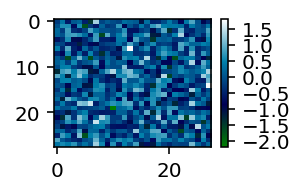

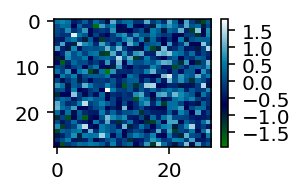

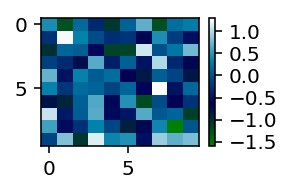

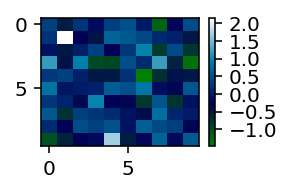

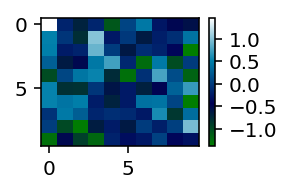

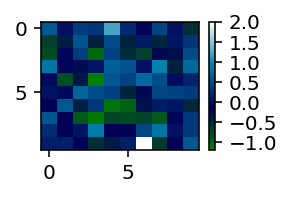

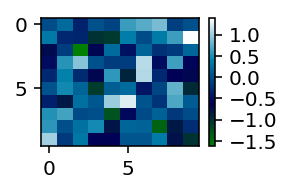

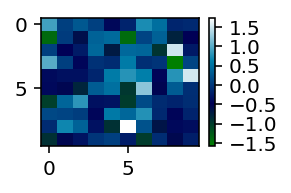

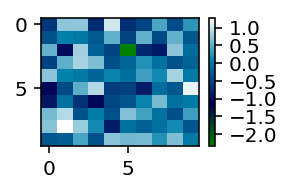

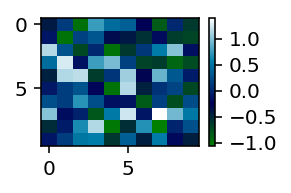

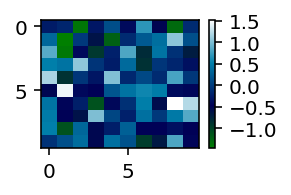

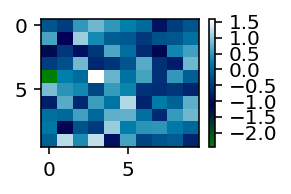

In [20]:
mat_a = np.reshape(best_individ.gene[0], (-1, 28, 28))

for ii in range(10):
    acc_plot = plt.subplot(333)
    plt.imshow(mat_a[ii], interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
    plt.colorbar()
    plt.show()

mat_b = np.reshape(best_individ.gene[2], (-1, 10, 10))

for ii in range(10):
    acc_plot = plt.subplot(333)
    plt.imshow(mat_b[ii], interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
    plt.colorbar()
    plt.show()

In [23]:
best_individ.gene[2]

array([[ -3.97842526e-02,   4.42336828e-01,   5.67361355e-01,
          1.15530932e+00,  -7.84469604e-01,   4.37624782e-01,
          6.16603255e-01,  -8.15170288e-01,   5.27278364e-01,
         -2.92347372e-01],
       [ -2.81485349e-01,  -2.55983949e-01,   2.49616265e-01,
         -9.39275384e-01,  -2.42555529e-01,  -4.46804538e-02,
          2.23369762e-01,  -1.88989729e-01,   4.53079760e-01,
         -5.08791655e-02],
       [ -8.39009225e-01,  -5.37170544e-02,  -6.25734091e-01,
          4.34788585e-01,   7.21185058e-02,  -4.36637402e-02,
          1.05061948e-01,  -1.26438767e-01,   1.82311922e-01,
         -2.10627854e-01],
       [ -6.37652397e-01,  -4.59401727e-01,  -1.13605618e-01,
         -2.53635764e-01,   7.93209791e-01,  -3.90813291e-01,
         -6.27288997e-01,  -9.39706266e-02,  -8.04364920e-01,
          5.02809525e-01],
       [  2.14780778e-01,  -1.70099184e-01,   1.39814913e-01,
         -5.80313325e-01,   1.38878763e-01,  -5.89156985e-01,
         -1.11521177e-01